# La gerarchia di Chomsky

In [ ]:
from liblet import Grammar, Derivation, ProductionGraph, iter2table

## Tipo 1

### Monotone

In [ ]:
# pag 20

monotonic = """
Sentence -> Name | List
List -> EndName | Name , List
Name -> tom | dick | harry
, EndName -> and Name
"""

In [ ]:
G_monotonic = Grammar.from_string(monotonic, False)
G_monotonic

Grammar(N={EndName, List, Name, Sentence}, T={,, and, dick, harry, tom}, P=(Sentence -> Name, Sentence -> List, List -> EndName, List -> Name , List, Name -> tom, Name -> dick, Name -> harry, , EndName -> and Name), S=Sentence)

### Context-sentitive

In [ ]:
# pag 20

context_sensitive = """
Sentence -> Name | List
List -> EndName | Name Comma List
Name -> tom | dick | harry
Comma EndName -> and EndName
and EndName -> and Name
Comma -> ,
"""

In [ ]:
G_cs = Grammar.from_string(context_sensitive, False)
G_cs

Grammar(N={Comma, EndName, List, Name, Sentence}, T={,, and, dick, harry, tom}, P=(Sentence -> Name, Sentence -> List, List -> EndName, List -> Name Comma List, Name -> tom, Name -> dick, Name -> harry, Comma EndName -> and EndName, and EndName -> and Name, Comma -> ,), S=Sentence)

In [ ]:
iter2table(G_cs.P)

In [ ]:
d = Derivation(G_cs).step(1, 0).step(3, 0).step(3, 2).step(2, 4).step(7, 3).step(8, 3).step(4, 0).step(5, 2).step(6, 4).step(9, 1)
d

Sentence -> List -> Name Comma List -> Name Comma Name Comma List -> Name Comma Name Comma EndName -> Name Comma Name and EndName -> Name Comma Name and Name -> tom Comma Name and Name -> tom Comma dick and Name -> tom Comma dick and harry -> tom , dick and harry

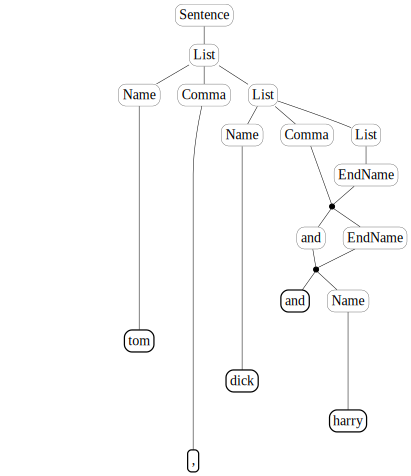

In [ ]:
ProductionGraph(d)

## <span style="color: red;">Esercizio facoltativo</span>

Un esempio interessante è quello del linguaggio $L = \{a^nb^nc^n \mid n > 0\}$; sapresete convincervi che esso è generato dalla seguente grammatica?

In [ ]:
anbncn = """
S -> a b c
S -> a S Q
b Q c -> b b c c
c Q -> Q c
"""

In [ ]:
G_anbncn = Grammar.from_string(anbncn, False)
iter2table(G_anbncn.P)

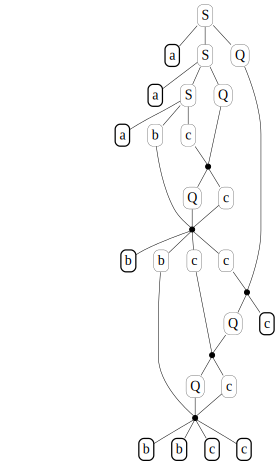

In [ ]:
d = Derivation(G_anbncn).step(1, 0).step(1, 1).step(0, 2).step(3, 4).step(2, 3).step(3, 6).step(3, 5).step(2, 4)
ProductionGraph(d)

## Tipo 2 (Context-free)

In [ ]:
# pag 23

context_free = """
Sentence -> Name | List and Name
List -> Name , List | Name
Name -> tom | dick | harry
"""

steps = (1, 0), (2, 0), (3, 2), (4, 0), (5, 2), (6, 4)

In [ ]:
G_cf = Grammar.from_string(context_free) # non c'è più il False

d = Derivation(G_cf)
for step in steps: d = d.step(*step)
d

Sentence -> List and Name -> Name , List and Name -> Name , Name and Name -> tom , Name and Name -> tom , dick and Name -> tom , dick and harry

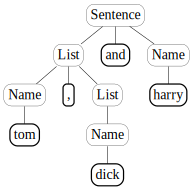

In [ ]:
# finalmente un albero! 

ProductionGraph(d)

## <span style="color: red;">Esempio per casa:</span> Tipo 3 (Regolari)

In [ ]:
# fig. 2.14, pag. 31

regular = """
Sentence -> tom | dick | harry | List
List -> tom ListTail | dick ListTail | harry ListTail
ListTail -> , List | and tom | and dick | and henry
"""

regular_strict = """
Sentence -> tom | dick | harry | List
List -> tom ListTail | dick ListTail | harry ListTail
ListTail -> , List | and Tom | and Dick | and Henry
Tom -> tom
Dick -> dick
Henry -> henry
"""

steps = (3, 0), (4, 0), (7, 1), (5, 2), (10, 3), (13, 4)

In [ ]:
G_regular = Grammar.from_string(regular_strict)

d = Derivation(G_regular)
for step in steps: d = d.step(*step)

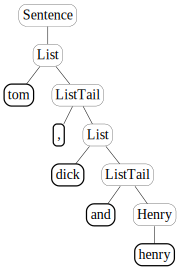

In [ ]:
# una "lista"

ProductionGraph(d)

# Grammatiche come generatori

In [ ]:
from liblet import Queue

In [ ]:
# compie max_step passi di visita in ampiezza del grafo
# implicito delle derivazioni, restituendo l'eneco di derivazioni
# che contucono ad una forma sentenziale composta solo di terminali

def produce(G, max_steps = 1):
    Q = Queue([Derivation(G)])
    D = [] 
    step = 0
    while Q:
        if step > max_steps: break
        step += 1
        derivation = Q.dequeue()
        if set(derivation.sentential_form()) <= G.T: 
            D.append(derivation)
        for pos, nprod in derivation.possible_steps():
            Q.enqueue(derivation.step(pos, nprod))
    return D

In [ ]:
# la grammatica dell'esercizio facoltativo

G = Grammar.from_string("""
S -> a b c
S -> a S Q
b Q c -> b b c c
c Q -> Q c
""", False)

In [ ]:
# 10k passi per 42 derivazioni!

deriv = produce(G, 10_000)
len(deriv)

42

In [ ]:
# ma solo 5 parole distinte (come mai?)

words = set(''.join(d.sentential_form()) for d in deriv)
len(words)

5

In [ ]:
print(words)

{'abc', 'aaabbbccc', 'aaaabbbbcccc', 'aaaaabbbbbccccc', 'aabbcc'}


# Fare pulizia nelle CF

## Una nozione di chiusura

In [ ]:
from liblet import closure

Applicare il decoratore [@closure](https://liblet.readthedocs.io/en/latest/api.html#liblet.decorators.closure) ad una funzione `f`  produce una funzione `F` che corrisponde all'applicazione di `f` iterata sino a quando l'argomento ed il valore restituito da quest'ultima coincidono.

In [ ]:
@closure
def add_smaller(S):
    return S | {x - 1 for x in S if x > 0}

In [ ]:
add_smaller({3, 5})

{0, 1, 2, 3, 4, 5}

## Eliminare simboli non produttivi e/o irraggiungibili

In [ ]:
# fig 2.27, pag. 49

G = Grammar.from_string("""
S -> A B | D E
A -> a
B -> b C
C -> c
D -> d F 
E -> e 
F -> f D
""")
G

Grammar(N={A, B, C, D, E, F, S}, T={a, b, c, d, e, f}, P=(S -> A B, S -> D E, A -> a, B -> b C, C -> c, D -> d F, E -> e, F -> f D), S=S)

In [ ]:
@closure
def productive(prod, G):
    for P in G.P:
        if set(P.rhs).issubset(prod): prod |= {P.lhs}
    return prod

productive(G.T, G)

frozenset({'A', 'B', 'C', 'E', 'S', 'a', 'b', 'c', 'd', 'e', 'f'})

In [ ]:
@closure
def reachable(reach, G):
    for P in G.P:
        if P.lhs in reach: reach |= set(P.rhs)
    return reach
    
reachable({G.S}, G)   

{'A', 'B', 'C', 'D', 'E', 'F', 'S', 'a', 'b', 'c', 'd', 'e', 'f'}

# <span style="color: red;">Esercizi per casa</span>


* Implementare una versione del *decoratore* `closure`.

* Implementare una funzione `clean(G, good)` che data una grammatica `G` e un 
  insieme di   simboli `good` restituisca una nuova grammatica ottenuta cancellando 
  da `G` i simboli non in `good` e le produzioni in cui figurano.

  Se invocata su `G_small` e avendo `{'A', 'B', 'S', 'a'}` come insieme di simboli
  da preservare, la funzione restituisce la grammatica `Grammar(N={A, B, S}, T={a}, P=(S -> A, S -> a, A -> A B, B -> a), S=S)`
  
* Usando tale funzione, mostrare che, dati 
  
        G0 = clean(G, productive(G.T, G))
        G1 = clean(G0, reachable({G0.S}, G0))
      
        G2 = clean(G, reachable({G.S}, G))
        G3 = clean(G2, productive(G2.T, G2))
        
  si ha che `G1` e`G3` sono diverse, ossia che rimuovere prima gli improduttivi e poi 
  gli irraggiungibili, o viceversa, non porta alla stessa grammatica (e solo `G1` è
  una grammatica *propria*).

* Scrivete una grammatica *context-free* per $L=\{ ww^R | w \in T^* \}$ (dove con 
  $w^R$ si intende la stringa $w$ scritta al contrario), e una
  di Tipo 1 *monotona* per $L=\{ ww | w \in T^* \}$.
